# Particle plot

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

pybamm.set_logging_level("INFO")

# load model
model = pybamm.lithium_ion.DFN()
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values
param.process_geometry(geometry)
param.process_model(model)

# set mesh
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 30, var.x_s: 30, var.x_p: 30, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
t_eval = np.linspace(0, 3600, 100)
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)
solution = solver.solve(model, t_eval)

# plot
plot = pybamm.QuickPlot(
    solution,
    [
        "Negative particle concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Positive particle concentration [mol.m-3]",
        "Current [A]",
        "Negative electrode potential [V]",
        "Electrolyte potential [V]",
        "Positive electrode potential [V]",
        "Terminal voltage [V]",
    ],
    time_unit="seconds",
    spatial_unit="um",
)

2022-01-04 11:30:28,555 - [INFO] base_battery_model.build_model(772): Start building Doyle-Fuller-Newman model
2022-01-04 11:30:28,628 - [INFO] base_battery_model.build_model(792): Finish building Doyle-Fuller-Newman model
2022-01-04 11:30:28,658 - [INFO] parameter_values.process_model(415): Start setting parameters for Doyle-Fuller-Newman model
2022-01-04 11:30:28,784 - [INFO] parameter_values.process_model(506): Finish setting parameters for Doyle-Fuller-Newman model
2022-01-04 11:30:28,785 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2022-01-04 11:30:29,091 - [INFO] discretisation.process_model(244): Finish discretising Doyle-Fuller-Newman model
2022-01-04 11:30:29,092 - [INFO] base_solver.solve(820): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2022-01-04 11:30:29,095 - [INFO] base_solver.set_up(111): Start solver set-up
2022-01-04 11:30:29,178 - [INFO] base_solver.set_up(683): Finish solver set-up
2022-01-0

In [2]:
def plot_particles(phi, Nr=100):
    r"""
    Plot the particles of radius r and variables phi

    Parameters
    ----------
    phi : (float)
        Array of variable phi to plot as function of r starting rx=0 and
        ending at rx=r. Shape [Np, Nr]

    Returns
    -------
    None.

    """
    Np, _ = np.shape(phi)
    fig, ax = plt.subplots(1, 1, figsize=(Np * 5, 5))
    length = 2 * Nr
    im = np.ones([length, Np * length])
    for p in range(Np):
        im[:, length * p : length * (p+1)] = color_particle(phi[p, :])
        
    mappable = ax.imshow(im, cmap="coolwarm")
    plt.colorbar(mappable)
    plt.tight_layout

def color_particle(phi, Nr=100):
    r"""
    Color a particle of radius with a vector of variable phi

    Parameters
    ----------
    phi : (float)
        Array of variable phi to plot as function of r starting rx=0 and
        ending at rx=r. Shape [Nr]

    Returns
    -------
    phi_map: np.ndarray [2*Nr, 2*Nr]

    """

    N = 2 * len(phi)
    im = np.indices([2*Nr, 2*Nr]).astype(float)
    im -= Nr
    r_map = np.sqrt(im[0, :, :] ** 2 + im[1, :, :] ** 2)
    r_map[r_map > Nr] = np.nan
    f = interp1d(np.linspace(0, Nr, len(phi)), phi)
    return f(r_map)

C:\Users\tom\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\tom\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


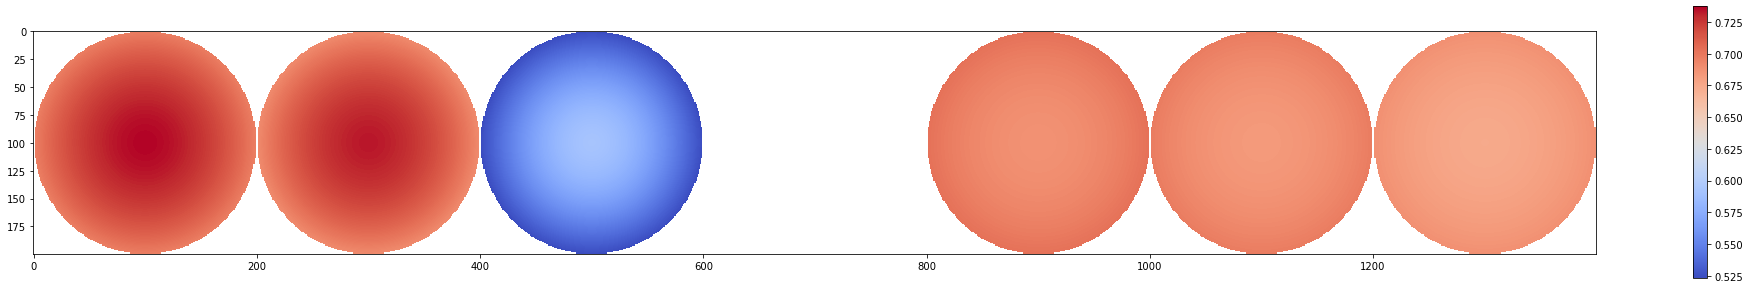

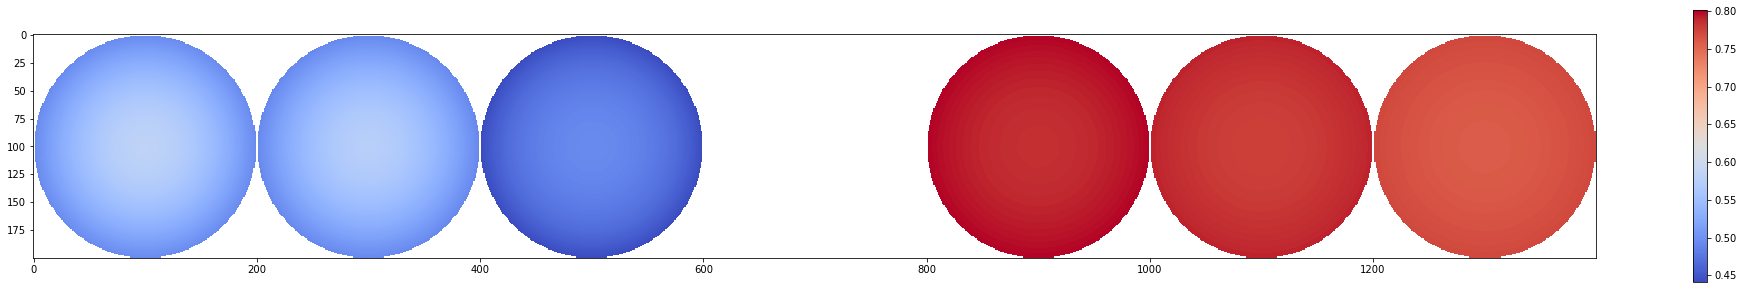

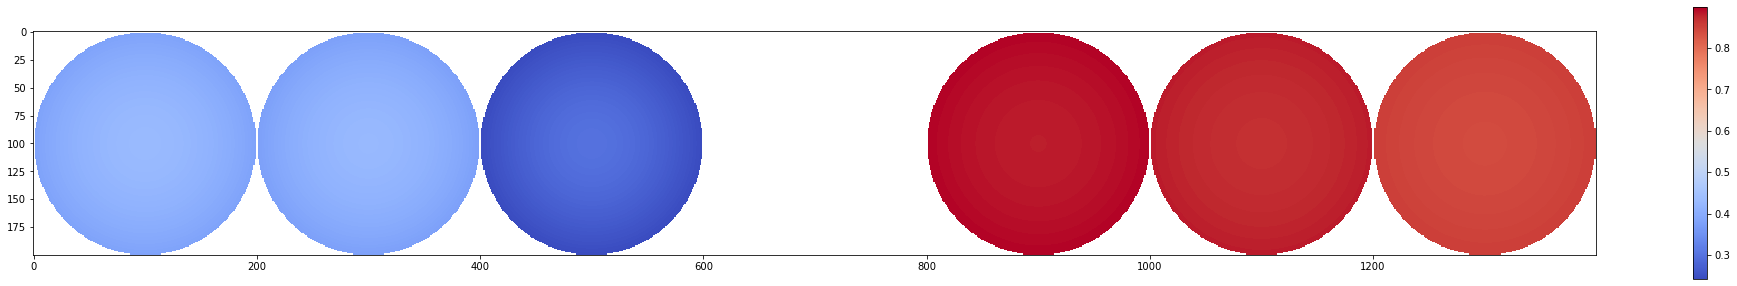

In [3]:
for tstep in [25, 50, 75]:
    C_n = solution["Negative particle concentration"].entries[:, :, tstep].T
    C_p = solution["Positive particle concentration"].entries[:, :, tstep].T
    C_s = C_n[:1, :] * np.nan
    dom = np.vstack((C_n[[0, 5, -1], :], C_s, C_p[[0, 5, -1], :]))
    plot_particles(dom)